# Python and Sionna RT Environment Config

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sionna
from sionna.rt import load_scene
# from sionna import load_scene
from matplotlib.colors import ListedColormap
import importlib
import SceneConfigSionna  
import BeamformingCalc
importlib.reload(SceneConfigSionna) 
importlib.reload(BeamformingCalc) 
from SceneConfigSionna import SceneConfigSionna
from BeamformingCalc import svd_bf, nulling_bf
from scipy.stats import chi2

✅ Using GPU: /physical_device:GPU:0
✅ Using GPU: /physical_device:GPU:0


In [2]:
# scenegen bbox -105.097 40.0371 -105.06 40.0697 --data-dir scenes/Denver
# scene = load_scene("../Denver/denver.xml")
# scene = load_scene("../blouder_plane_itu3/boulder_plane_itu.xml")
# scene = load_scene("../Denver_Scene/Boulder2_2/Boulder2.xml")
scene = load_scene("Denver_Scene/Boulder/Boulder.xml")

Parmeters

In [3]:
n_sim = 80
nbs = 1
nsect = 3
ntn_rx=300
# ntn_rx=30
tn_rx=200
bs_dist_min=35
bs_dist_max=3000

tx_antenna_rows = 4
tx_antenna_cols = 16
tn_rx_antenna_rows = 1
tn_rx_antenna_cols = 1
tx_antennas = tx_antenna_rows*tx_antenna_cols
tn_antennas = tn_rx_antenna_rows*tn_rx_antenna_cols



EkT = -174    # Noise energy in dBm/Hz, antenna temperature for vsat: 290K
B = 100e6
Tx_power_dbm = 30 # dbm
Tx_power = 10 ** ((Tx_power_dbm - 30) / 10)
Tx_power_handheld_dbm = 23 # dbm
Tx_power_handheld = 10 ** ((Tx_power_handheld_dbm - 30) / 10)




NF = 7  # Noise figure in dB
NF_vsat = 3
NF_bs = 2
# reference signal duration
preamble_time = 20e-6 
N0_dBm = EkT + 10 * np.log10(B) + NF
N0 = 10 ** ((N0_dBm - 30) / 10)
N0_vsat =  10 ** ((EkT + 10 * np.log10(B) + NF_vsat - 30) / 10)
N0_bs =  10 ** ((EkT + 10 * np.log10(B) +NF_bs - 30) / 10)
# For channel estimation interference distribution, h_hat = h + CN~(0, N0/(Tx_power*time))

N0_sigma =  10 ** ((EkT+NF_bs - 30) / 10) /Tx_power/preamble_time
N0_sigma_handheld =  10 ** ((EkT+NF_bs - 30) / 10) /Tx_power_handheld/preamble_time




snr_threshold = -10  # SNR threshold in dB
inr_threshold = -6
h_ntn_snr_th = np.sqrt(10**(inr_threshold/10)*N0_bs*tx_antennas /Tx_power)
h_tn_th = np.sqrt(10**(snr_threshold/10)*N0_bs*tx_antennas /Tx_power)
Threshold_peft = 10*np.log10(np.abs(h_tn_th)**2)



p_fa = 1/B
pfa_treshold =  chi2.ppf(1 - p_fa, 2 * tx_antennas) / 2  # t = Z/2
h_ntn_pfa_th =np.sqrt(pfa_treshold*N0_sigma)
h_tn_pfa_th =np.sqrt(pfa_treshold*N0_sigma_handheld)
Threshold = 10*np.log10(np.abs(h_ntn_pfa_th)**2)
Threshold_handheld = 10*np.log10(np.abs(h_tn_pfa_th)**2)

print(f"h_ntn_snr_th (from SNR threshold): {h_ntn_snr_th:.4e}")
print(f"p_fa (false alarm rate): {p_fa:.2e}")
print(f"pfa_treshold(t) (false alarm rate): {pfa_treshold}")
print(f"h_ntn_pfa_th (from chi² Pfa threshold): {h_ntn_pfa_th}")
print(f"h_ntn_pfa_th (in dB): {Threshold }")
print(f"h_tn_pfa_th (in dB): {Threshold_handheld }")
print(f"Threshold_peft (in dB): {Threshold_peft }")

h_ntn_snr_th (from SNR threshold): 3.1849e-06
p_fa (false alarm rate): 1.00e-08
pfa_treshold(t) (false alarm rate): 119.48150869313969
h_ntn_pfa_th (from chi² Pfa threshold): 1.9414908632222642e-07
h_ntn_pfa_th (in dB): -134.23729297860373
h_tn_pfa_th (in dB): -127.23729297860373
Threshold_peft (in dB): -113.93820026016112


Run Simu

In [4]:
interference_ntn = 0   
Used_tn = 0   
total_ntn = 0

inr_list = []


snr_list = []
Q_1_dB_list = []
h_ntn_dB_list = []
h_tn_dB_list = []
# lambda_ranges = [1e1,1e2,1e3,1e4,1e5,1e6] 


# antenna_pairs = [
#     (4, 16),
#     (4, 32),
#     (4, 64),
#     (8, 128),
#     (8, 256)
# ]

antenna_pairs = [
    (4, 16),
    (4, 48),
    (4, 128)
]
total_ntn_dict = {(r,c): 0 for (r,c) in antenna_pairs}

lambda_ = 1e11 
eigen_value_dict     = {(r,c): [] for (r,c) in antenna_pairs}
snr_nulling_dict     = {(r,c): [] for (r,c) in antenna_pairs}
snr_nulling_hat_dict = {(r,c): [] for (r,c) in antenna_pairs}
snr_degration_dict   = {(r,c): [] for (r,c) in antenna_pairs}
inr_nulling_dict     = {(r,c): [] for (r,c) in antenna_pairs}
inr_nulling_hat_dict = {(r,c): [] for (r,c) in antenna_pairs}
inr_degration_dict = {(r, c): [] for (r, c) in antenna_pairs}

v_null_record        = {(r,c): [] for (r,c) in antenna_pairs}
snr_dict = {(r,c): [] for (r,c) in antenna_pairs}
inr_dict = {(r,c): [] for (r,c) in antenna_pairs}
w_t_record = []  # List of w_t vectors

   
for sim in tqdm(range(n_sim), desc="Simulations"):     
    
    azimuth = np.random.uniform(0, 360)
    elevation = np.random.uniform(25, 90)
    
    SceneConfig = SceneConfigSionna(scene, nbs = nbs, nsect = nsect, fc =9.999e9)
    SceneConfig.compute_positions(ntn_rx=ntn_rx, tn_rx=tn_rx,  azimuth=azimuth, elevation =elevation,
                                    centerBS=True, bs_dist_min=bs_dist_min, bs_dist_max=bs_dist_max)
    for (tx_antenna_rows, tx_antenna_cols) in antenna_pairs:
        ntn_kept_indices = [] 
        tx_antennas = tx_antenna_rows*tx_antenna_cols
        pfa_treshold =  chi2.ppf(1 - p_fa, 2 * tx_antennas) / 2  # t = Z/2
        h_ntn_pfa_th =np.sqrt(pfa_treshold*N0_sigma)
        h_tn_pfa_th =np.sqrt(pfa_treshold*N0_sigma_handheld)
        SceneConfig.compute_paths(tx_rows = tx_antenna_rows, tx_cols = tx_antenna_cols, tn_rx_rows = tn_rx_antenna_rows, 
                                tn_rx_cols = tn_rx_antenna_cols, max_depth=3)
        det_ntn_max = 0
        a_ntn = SceneConfig.a_ntn
        a_tn = SceneConfig.a_tn
        bs_tn_pos = SceneConfig.bs_tn_pos
        tx_pos = SceneConfig.tx_pos
        rx_ntn_pos = SceneConfig.rx_ntn_pos

        h_tn_all = np.sum(SceneConfig.a_tn, axis = 4).squeeze()
        if h_tn_all.ndim == 3:
            h_tn_all = h_tn_all.reshape(h_tn_all.shape[0], 1, h_tn_all.shape[1], h_tn_all.shape[2])
        h_ntn_all = np.sum(SceneConfig.a_ntn, axis = 4).squeeze()
        if h_ntn_all.ndim == 2:
            h_ntn_all = h_ntn_all.reshape(1, h_ntn_all.shape[0], h_ntn_all.shape[1])
            
        interference_ntn += np.count_nonzero(np.any(h_ntn_all != 0, axis=(1, 2)))

        best_tx_list = []  # Stores the best t for each r
        bs_tx_tn = []  # Stores the corresponding bs_tn_pos
        w_t_grouped, w_r_grouped, h_grouped = {}, {}, {}
            
        for r in range(bs_tn_pos.shape[0]):  # Iterate over all tx antennas
            max_snr = -np.inf  # Initialize max SNR for each r
            best_tx = None  # Store the best t for the current r
            best_w_t = None  # Store the best w_t
            best_w_r = None  # Store the best w_r
            best_h_tn = None

            for t in range(nbs * nsect):  # Iterate over all tn-users
                h_tn = h_tn_all[r, :, t, :].T  
                noise_handheld = np.sqrt(N0_sigma_handheld/2)  * (np.random.randn(*h_tn.shape) + 1j * np.random.randn(*h_tn.shape))
                h_tn_hat = h_tn + noise_handheld
                h_tn_hat_norm = np.linalg.norm(h_tn_hat, ord='fro')
                h_tn_norm = np.linalg.norm(h_tn, ord='fro')      

                if np.any(h_tn_hat_norm > h_tn_pfa_th) and np.any(h_tn_norm > h_tn_th):  # Consider significant channels only
                    # h_tn_dB = 10 * np.log10(h_tn_norm**2)
                    # h_tn_dB_list.append(h_tn_dB.item())
                    w_t, w_r = svd_bf(h_tn,tx_antennas)
                    # Compute SNR
                    snr = 10 * np.log10((np.abs(w_t.conj().T @ h_tn @ w_r)**2) * Tx_power / N0)

                    # Update the maximum SNR for the current tn_rx
                    if snr > max_snr:   # Consider significant channels only
                        max_snr = snr
                        best_tx = t     # Store the best tx
                        best_w_t = w_t  # Store the best w_t
                        best_w_r = w_r  # Store the best w_r
                        best_h_tn = h_tn

            # Only add if max SNR is above the threshold
            if best_tx is not None:
                best_tx_list.append(best_tx)  # Store best t for this r
                snr_dict[(tx_antenna_rows, tx_antenna_cols)].append(max_snr.item())
                bs_tx_tn.append(bs_tn_pos[r, :])  # Append the corresponding bs_tn_pos row
                # Store directly in grouped dictionaries
                if best_tx not in w_t_grouped:
                    w_t_grouped[best_tx], w_r_grouped[best_tx], h_grouped[best_tx] = [], [], []

                w_t_grouped[best_tx].append(best_w_t)
                w_r_grouped[best_tx].append(best_w_r)
                h_grouped[best_tx].append(best_h_tn)

        # Convert lists to NumPy arrays for consistency
        bs_tx_tn = np.array(bs_tx_tn) if bs_tx_tn else np.empty((0, bs_tn_pos.shape[1]))
        best_tx_list = np.array(best_tx_list)


        # Convert lists to NumPy arrays for consistency
        for best_tx in w_t_grouped:
            w_t_grouped[best_tx] = np.array(w_t_grouped[best_tx])
            w_r_grouped[best_tx] = np.array(w_r_grouped[best_tx])
            h_grouped[best_tx] = np.array(h_grouped[best_tx])

        _, counts = np.unique(best_tx_list, return_counts=True)
        min_count = np.min(counts)
        # Used_tn += min_count


        for m in range(min_count):        
                
            h_i_gain_sum = np.zeros((ntn_rx,), dtype=np.float64)
            h_i_null_gain = np.zeros((ntn_rx,), dtype=np.float64)
            h_i_null_gain_hat= np.zeros((ntn_rx,), dtype=np.float64)
            
            for t in range(nbs * nsect):
                w_t = w_t_grouped[t][m]
                w_r = w_r_grouped[t][m]
                h = h_grouped[t][m]
                det_ntn = 0
            
                h_i = h_ntn_all[:, t, :]
                noise = np.sqrt(N0_sigma/2)  * (np.random.randn(*h_i.shape) + 1j * np.random.randn(*h_i.shape))
                h_i_hat = h_i + noise
                
                h_i_norms = np.linalg.norm(h_i, axis=1)
                h_i_hat_norms = np.linalg.norm(h_i_hat, axis=1)

                mask = h_i_hat_norms <= h_ntn_pfa_th
                indices_kept = np.where(~mask)[0]  # 被保留的 index（非 mask 的）
                ntn_kept_indices.append(indices_kept)
                h_i_hat = h_i + noise
                h_i[mask] = 0
                h_i_hat[mask] = 0
                
                det_ntn = np.count_nonzero(np.any(h_i != 0, axis=(1)))
                if det_ntn> det_ntn_max:
                    det_ntn_max = det_ntn
                

                h_i = h_i.reshape(ntn_rx, -1, 1)  # Reshape to (ntn_rx, tx_antennas, 1)
                # interference_term = np.zeros((tx_antennas,tx_antennas), dtype=np.complex64) 
                interference_term = np.matmul(h_i, h_i.conj().transpose(0, 2, 1))  
                interference_term = np.sum(interference_term, axis=0)   # Sum over all ntn-users
                
                h_i_hat = h_i_hat.reshape(ntn_rx, -1, 1)  # Reshape to (ntn_rx, tx_antennas, 1)
                interference_term_hat = np.matmul(h_i_hat, h_i_hat.conj().transpose(0, 2, 1))  
                interference_term_hat = np.sum(interference_term_hat, axis=0)   # Sum over all ntn-users
                
                h_i_gain = (np.abs(np.matmul(w_t.conj().T, h_i)) ** 2).squeeze()  # Shape: (ntn_rx)
                h_i_gain_sum += h_i_gain  # Element-wise sum over all t
                # w_t_record.append(w_t.copy()) 
                
                v_null, Q_1, Q_2,max_eigen_value = nulling_bf(h, w_r, interference_term, lambda_,tx_antennas)
                v_null_hat,_,_,_ = nulling_bf(h, w_r, interference_term_hat, lambda_,tx_antennas)
                # v_null_record[lambda_].append(v_null.copy())
                eigen_value_dict[(tx_antenna_rows, tx_antenna_cols)].append(max_eigen_value.item())

                snr_nulling = 10 * np.log10((np.abs(v_null.conj().T @ h @ w_r) ** 2) * Tx_power / N0)
                snr_nulling_dict[(tx_antenna_rows, tx_antenna_cols)].append(snr_nulling.item())

                snr_nulling_hat = 10 * np.log10((np.abs(v_null_hat.conj().T @ h @ w_r) ** 2) * Tx_power / N0)
                snr_nulling_hat_dict[(tx_antenna_rows, tx_antenna_cols)].append(snr_nulling_hat.item())
                
                snr_degration = 10 * np.log10((np.abs(w_t.conj().T @ h @ w_r) ** 2)/(np.abs(v_null_hat.conj().T @ h @ w_r) ** 2) )
                snr_degration_dict[(tx_antenna_rows, tx_antenna_cols)].append(snr_degration.item())

                # Compute nulling interference gain
                h_i_null_gain     += (np.abs(np.matmul(v_null.conj().T, h_i))**2).squeeze()
                h_i_null_gain_hat += (np.abs(np.matmul(v_null_hat.conj().T, h_i))**2).squeeze()
            
            inr = 10 * np.log10(h_i_gain_sum*Tx_power/N0)
            inr_dict[(tx_antenna_rows, tx_antenna_cols)].extend(inr)
        
            inr_nulling     = 10 * np.log10(h_i_null_gain     * Tx_power / N0)
            inr_nulling_hat = 10 * np.log10(h_i_null_gain_hat * Tx_power / N0)
            
            inr_degration = inr - inr_nulling
            inr_degration_dict[(tx_antenna_rows, tx_antenna_cols)].extend(inr_degration)

            inr_nulling_dict[(tx_antenna_rows, tx_antenna_cols)].extend(inr_nulling)
            inr_nulling_hat_dict[(tx_antenna_rows, tx_antenna_cols)].extend(inr_nulling_hat)
            
        unique_ntn_kept = len(np.unique(np.concatenate(ntn_kept_indices)))
        total_ntn_dict[(tx_antenna_rows, tx_antenna_cols)] += unique_ntn_kept
            
print("total_ntn per antenna pair (averaged over sims):")
for (r, c) in antenna_pairs:
    avg_total_ntn = total_ntn_dict[(r,c)] / n_sim/3
    print(f"  ({r}x{c}): {avg_total_ntn:.2f}")

Simulations:   0%|          | 0/80 [00:00<?, ?it/s]/tmp/ipykernel_17695/3260540341.py:201: RuntimeWarning: divide by zero encountered in log10
  inr = 10 * np.log10(h_i_gain_sum*Tx_power/N0)
/tmp/ipykernel_17695/3260540341.py:204: RuntimeWarning: divide by zero encountered in log10
  inr_nulling     = 10 * np.log10(h_i_null_gain     * Tx_power / N0)
/tmp/ipykernel_17695/3260540341.py:205: RuntimeWarning: divide by zero encountered in log10
  inr_nulling_hat = 10 * np.log10(h_i_null_gain_hat * Tx_power / N0)
/tmp/ipykernel_17695/3260540341.py:207: RuntimeWarning: invalid value encountered in subtract
  inr_degration = inr - inr_nulling
Simulations: 100%|██████████| 80/80 [33:22<00:00, 25.03s/it]

total_ntn per antenna pair (averaged over sims):
  (4x16): 28.71
  (4x48): 31.66
  (4x128): 34.11


Different Lambda_

In [43]:
xx = 1/20e6
10*np.log10(xx)

-73.01029995663981

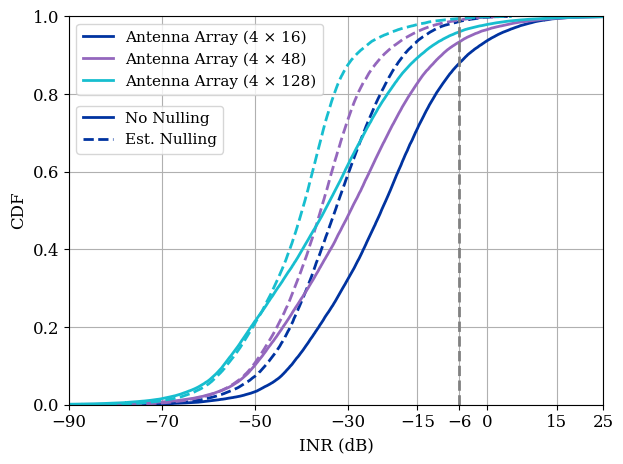

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 12,
    "legend.fontsize": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})
plt.figure()

# 固定三种颜色：黑、蓝、红
color_list = ['black', 'blue', 'red']
color_list = ['#0033A0', '#9467bd', '#17becf']
pair_colors = {pair: color_list[i % len(color_list)] for i, pair in enumerate(antenna_pairs)}

def format_pair(pair):
    return f"{pair[0]} × {pair[1]}"

# 用于记录legend的句柄
handles_color = []
labels_color = []

for pair in antenna_pairs:
    raw_inr_vals = np.array(inr_dict[pair])
    # raw_inr_nulling_vals = np.array(inr_nulling_dict[pair])
    raw_inr_nulling_vals = np.array(inr_nulling_hat_dict[pair])
    

    # 过滤无效值
    mask_inr = ~np.isnan(raw_inr_vals) & np.isfinite(raw_inr_vals)
    mask_inr_nulling = ~np.isnan(raw_inr_nulling_vals) & np.isfinite(raw_inr_nulling_vals)
    inr_vals = raw_inr_vals[mask_inr]
    inr_nulling_vals = raw_inr_nulling_vals[mask_inr_nulling]

    if len(inr_vals) == 0 and len(inr_nulling_vals) == 0:
        continue

    inr_vals = np.sort(inr_vals)
    inr_nulling_vals = np.sort(inr_nulling_vals)

    N = len(inr_vals)
    M = len(inr_nulling_vals)
    cdf_inr = np.arange(1, N + 1) / N if N > 0 else []
    cdf_inr_nulling = np.arange(1, M + 1) / M if M > 0 else []

    color = pair_colors[pair]
    if len(cdf_inr) > 0:
        plt.plot(inr_vals, cdf_inr, '-', color=color, linewidth=2)
    if len(cdf_inr_nulling) > 0:
        plt.plot(inr_nulling_vals, cdf_inr_nulling, '--', color=color, linewidth=2)

    # 为第一个legend收集信息（只添加一次每个pair）
    handles_color.append(Line2D([0], [0], color=color, linewidth=2))
    labels_color.append(f"Antenna Array ({format_pair(pair)})")

# 灰色竖线
plt.axvline(x=-6, color='grey', linestyle='--', linewidth=2)

# 轴设置
plt.xlabel("INR (dB)")
plt.ylabel("CDF")
plt.xlim([-90, 25])
plt.ylim([0, 1])
plt.xticks([-90, -70, -50, -30, -15, -6, 0, 15, 25])
plt.grid(True)

# 第一个 legend：颜色与 pair 映射（左上）
legend1 = plt.legend(
    handles=handles_color,
    labels=labels_color,
    loc="upper left",
    bbox_to_anchor=(0.0001, 0.9999)  # 左上角微调
)

# 获取 legend1 的坐标，设置 legend2 紧随其下
legend1_box = legend1.get_frame().get_bbox().transformed(plt.gcf().transFigure.inverted())
x0, y0 = legend1_box.x0, legend1_box.y0  # y0 是 legend1 底部

# 第二个 legend：线型说明（紧跟在 legend1 下方）
legend2_elements = [
    Line2D([0], [0], color='#0033A0', linestyle='-', lw=2, label='No Nulling'),
    # Line2D([0], [0], color='#0033A0', linestyle='--', lw=2, label='Perfect Nulling')
    Line2D([0], [0], color='#0033A0', linestyle='--', lw=2, label='Est. Nulling')
]
legend2 = plt.legend(
    handles=legend2_elements,
    loc='upper left',
    bbox_to_anchor=(0.0001, 0.79),  # 明确设定一个靠近 legend1 的位置
    # title='Line Style'
)

# 把 legend1 放回图中（否则会被 legend2 覆盖）
plt.gca().add_artist(legend1)
plt.tight_layout()
# plt.savefig("ResultPlot/inr_cdf_antenna5.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("ResultPlot/inr_cdf_antenna5.png", format="png", bbox_inches="tight")

plt.show()


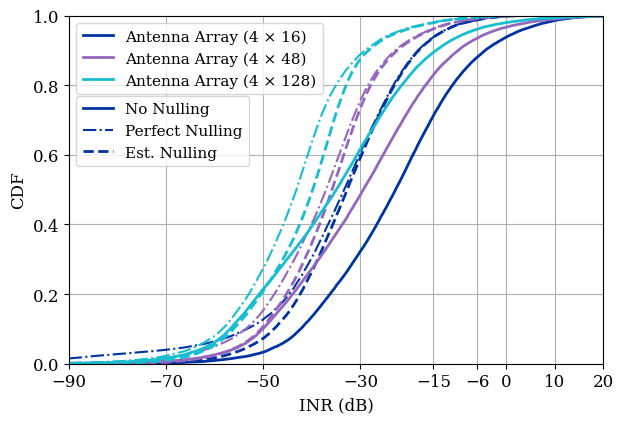

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# 字体和格式设置
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 12,
    "legend.fontsize": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

plt.figure(figsize=(6.4, 4.4))

# 固定三种颜色
color_list = ['#0033A0', '#9467bd', '#17becf']
pair_colors = {pair: color_list[i % len(color_list)] for i, pair in enumerate(antenna_pairs)}

def format_pair(pair):
    return f"{pair[0]} × {pair[1]}"

# legend用的句柄和标签
handles_color = []
labels_color = []

for pair in antenna_pairs:
    raw_inr_vals = np.array(inr_dict[pair])
    raw_inr_nulling_vals = np.array(inr_nulling_dict[pair])
    raw_inr_nulling_hat_vals = np.array(inr_nulling_hat_dict[pair])

    # 清洗数据
    mask_inr = ~np.isnan(raw_inr_vals) & np.isfinite(raw_inr_vals)
    mask_inr_nulling = ~np.isnan(raw_inr_nulling_vals) & np.isfinite(raw_inr_nulling_vals)
    mask_inr_nulling_hat = ~np.isnan(raw_inr_nulling_hat_vals) & np.isfinite(raw_inr_nulling_hat_vals)

    inr_vals = np.sort(raw_inr_vals[mask_inr])
    inr_nulling_vals = np.sort(raw_inr_nulling_vals[mask_inr_nulling])
    inr_nulling_hat_vals = np.sort(raw_inr_nulling_hat_vals[mask_inr_nulling_hat])

    cdf_inr = np.arange(1, len(inr_vals) + 1) / len(inr_vals) if len(inr_vals) > 0 else []
    cdf_inr_nulling = np.arange(1, len(inr_nulling_vals) + 1) / len(inr_nulling_vals) if len(inr_nulling_vals) > 0 else []
    cdf_inr_nulling_hat = np.arange(1, len(inr_nulling_hat_vals) + 1) / len(inr_nulling_hat_vals) if len(inr_nulling_hat_vals) > 0 else []

    color = pair_colors[pair]

    if len(cdf_inr) > 0:
        plt.plot(inr_vals, cdf_inr, '-', color=color, linewidth=2)
    if len(cdf_inr_nulling) > 0:
        plt.plot(inr_nulling_vals, cdf_inr_nulling, '-.', color=color, linewidth=1.5)
    if len(cdf_inr_nulling_hat) > 0:
        plt.plot(inr_nulling_hat_vals, cdf_inr_nulling_hat, '--', color=color, linewidth=2)

    # legend 信息（每对 pair 只加一次）
    handles_color.append(Line2D([0], [0], color=color, linewidth=2))
    labels_color.append(f"Antenna Array ({format_pair(pair)})")

# 灰色参考线
# plt.axvline(x=-6, color='grey', linestyle='--', linewidth=2)

# 坐标轴设置
plt.xlabel("INR (dB)")
plt.ylabel("CDF")
plt.xlim([-90, 20])
plt.ylim([0, 1])
plt.xticks([-90, -70, -50, -30, -15, -6, 0, 10,20])
plt.grid(True)

# Legend 1：颜色代表不同 array 配置
legend1 = plt.legend(
    handles=handles_color,
    labels=labels_color,
    loc="upper left",
    bbox_to_anchor=(0.0001, 0.9999)
)

# 第二个 legend（线型说明）
legend2_elements = [
    Line2D([0], [0], color='#0033A0', linestyle='-', lw=2, label='No Nulling'),
    Line2D([0], [0], color='#0033A0', linestyle='-.', lw=1.5, label='Perfect Nulling'),
    Line2D([0], [0], color='#0033A0', linestyle='--', lw=2, label='Est. Nulling')
]
legend2 = plt.legend(
    handles=legend2_elements,
    loc='upper left',
    bbox_to_anchor=(0.0001, 0.79)
)

# 放回 legend1 防止被覆盖
plt.gca().add_artist(legend1)

# 保存图像
plt.tight_layout()
plt.savefig("ResultPlot/inr_cdf_antenna.pdf", format="pdf", bbox_inches="tight")
plt.savefig("ResultPlot/inr_cdf_antenna.png", format="png", bbox_inches="tight")
plt.show()


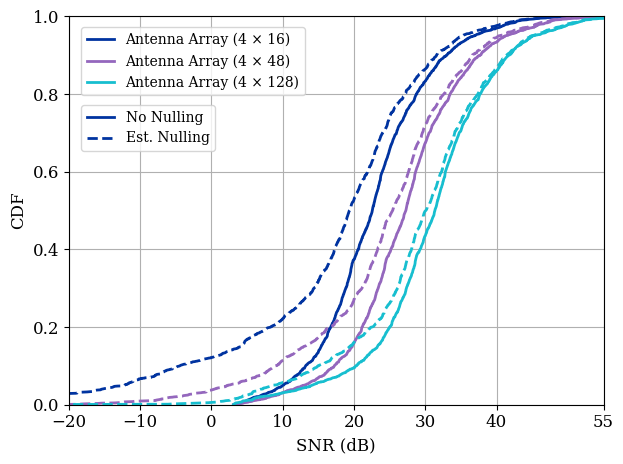

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 12,
    "legend.fontsize": 10,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})
plt.figure()
main_ax = plt.gca()

# 固定颜色
color_list = ['#0033A0', '#9467bd', '#17becf']
pair_colors = {pair: color_list[i % len(color_list)] for i, pair in enumerate(antenna_pairs)}

# Label 格式函数
def format_pair(pair):
    return f"{pair[0]} × {pair[1]}"

# 保存 legend 用的句柄
handles_color = []
labels_color = []

# 主图 SNR 曲线绘制
for pair in antenna_pairs:
    color = pair_colors[pair]

    # 原始 SNR
    snr_vals = np.array(snr_dict[pair])
    snr_vals = snr_vals[np.isfinite(snr_vals)]
    if len(snr_vals) > 0:
        snr_vals = np.sort(snr_vals)
        cdf_snr = np.arange(1, len(snr_vals) + 1) / len(snr_vals)
        main_ax.plot(snr_vals, cdf_snr, '-', color=color, linewidth=2)

    # SNR with nulling
    snr_nulling_vals = np.array(snr_nulling_hat_dict[pair])
    snr_nulling_vals = snr_nulling_vals[np.isfinite(snr_nulling_vals)]
    if len(snr_nulling_vals) > 0:
        snr_nulling_vals = np.sort(snr_nulling_vals)
        cdf_snr_nulling = np.arange(1, len(snr_nulling_vals) + 1) / len(snr_nulling_vals)
        main_ax.plot(snr_nulling_vals, cdf_snr_nulling, '--', color=color, linewidth=2)

    # 保存颜色图例信息
    handles_color.append(Line2D([0], [0], color=color, lw=2))
    labels_color.append(f"Antenna Array ({format_pair(pair)})")

# 坐标轴与图形设置
main_ax.set_xlabel("SNR (dB)")
main_ax.set_ylabel("CDF")
main_ax.set_xlim([-20, 55])
main_ax.set_ylim([0, 1])
main_ax.set_xticks([-20, -10, 0, 10, 20, 30, 40, 55])
main_ax.grid(True)

# 添加 legend1：颜色对应 pair
legend1 = plt.legend(handles=handles_color, labels=labels_color, loc="upper left", bbox_to_anchor=(0.01, 0.99))

# legend2：线型说明
legend2_elements = [
    Line2D([0], [0], color='#0033A0', linestyle='-', lw=2, label='No Nulling'),
    Line2D([0], [0], color='#0033A0', linestyle='--', lw=2, label='Est. Nulling')
]
legend2 = plt.legend(
    handles=legend2_elements,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.79)
)
main_ax.add_artist(legend1)

# # ----------------------------------
# # ✅ 添加 inset 小窗，放大 30–50 dB
# # ----------------------------------
# inset_ax = inset_axes(main_ax, width="60%", height="60%", loc='upper right',
#                       bbox_to_anchor=(-0.02, -0.08, 0.3, 0.75), bbox_transform=main_ax.transAxes)

# for pair in antenna_pairs:
#     color = pair_colors[pair]

#     # 原始 SNR
#     snr_vals = np.array(snr_dict[pair])
#     snr_vals = snr_vals[np.isfinite(snr_vals)]
#     if len(snr_vals) > 0:
#         snr_vals = np.sort(snr_vals)
#         cdf_snr = np.arange(1, len(snr_vals) + 1) / len(snr_vals)
#         inset_ax.plot(snr_vals, cdf_snr, '-', color=color, linewidth=2)

#     # SNR with nulling
#     snr_nulling_vals = np.array(snr_nulling_dict[pair])
#     snr_nulling_vals = snr_nulling_vals[np.isfinite(snr_nulling_vals)]
#     if len(snr_nulling_vals) > 0:
#         snr_nulling_vals = np.sort(snr_nulling_vals)
#         cdf_snr_nulling = np.arange(1, len(snr_nulling_vals) + 1) / len(snr_nulling_vals)
#         inset_ax.plot(snr_nulling_vals, cdf_snr_nulling, '--', color=color, linewidth=2)

# inset_ax.set_xlim([10, 30])
# inset_ax.set_ylim([0, 0.65])
# inset_ax.grid(False)
# inset_ax.tick_params(labelsize=9)

plt.tight_layout()
# plt.savefig("ResultPlot/snr_cdf_antenna5.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("ResultPlot/snr_cdf_antenna5.png", format="png", bbox_inches="tight")
plt.show()


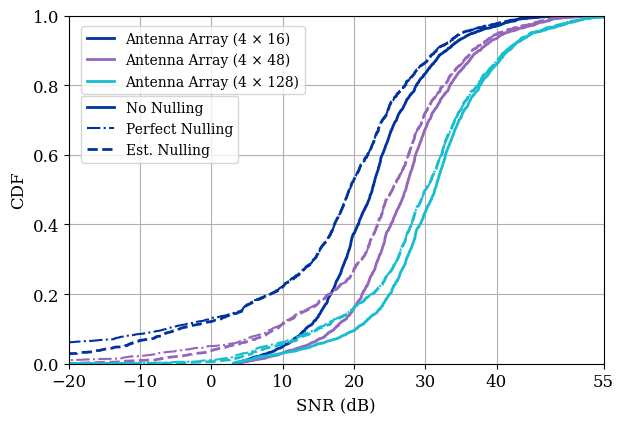

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 12,
    "legend.fontsize": 10,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})
plt.figure(figsize=(6.4, 4.4))
main_ax = plt.gca()

# 固定颜色
color_list = ['#0033A0', '#9467bd', '#17becf']
pair_colors = {pair: color_list[i % len(color_list)] for i, pair in enumerate(antenna_pairs)}

# Label 格式函数
def format_pair(pair):
    return f"{pair[0]} × {pair[1]}"

# 保存 legend 用的句柄
handles_color = []
labels_color = []

# 主图 SNR 曲线绘制
for pair in antenna_pairs:
    color = pair_colors[pair]

    # 原始 SNR
    snr_vals = np.array(snr_dict[pair])
    snr_vals = snr_vals[np.isfinite(snr_vals)]
    if len(snr_vals) > 0:
        snr_vals = np.sort(snr_vals)
        cdf_snr = np.arange(1, len(snr_vals) + 1) / len(snr_vals)
        main_ax.plot(snr_vals, cdf_snr, '-', color=color, linewidth=2)

    # SNR with perfect nulling
    snr_nulling_vals = np.array(snr_nulling_dict[pair]) 
    snr_nulling_vals = snr_nulling_vals[np.isfinite(snr_nulling_vals)]
    if len(snr_nulling_vals) > 0:
        snr_nulling_vals = np.sort(snr_nulling_vals)
        cdf_snr_nulling = np.arange(1, len(snr_nulling_vals) + 1) / len(snr_nulling_vals)
        main_ax.plot(snr_nulling_vals, cdf_snr_nulling, '-.', color=color, linewidth=1.5)

    # SNR with estimated nulling
    snr_nulling_hat_vals = np.array(snr_nulling_hat_dict[pair]) 
    snr_nulling_hat_vals = snr_nulling_hat_vals[np.isfinite(snr_nulling_hat_vals)]
    if len(snr_nulling_hat_vals) > 0:
        snr_nulling_hat_vals = np.sort(snr_nulling_hat_vals)
        cdf_snr_nulling_hat = np.arange(1, len(snr_nulling_hat_vals) + 1) / len(snr_nulling_hat_vals)
        main_ax.plot(snr_nulling_hat_vals, cdf_snr_nulling_hat, '--', color=color, linewidth=2)

    # 保存颜色图例信息
    handles_color.append(Line2D([0], [0], color=color, lw=2))
    labels_color.append(f"Antenna Array ({format_pair(pair)})")

# 坐标轴与图形设置
main_ax.set_xlabel("SNR (dB)")
main_ax.set_ylabel("CDF")
main_ax.set_xlim([-20, 55])
main_ax.set_ylim([0, 1])
main_ax.set_xticks([-20, -10, 0, 10, 20, 30, 40, 55])
main_ax.grid(True)

# 添加 legend1：颜色对应 pair
legend1 = plt.legend(handles=handles_color, labels=labels_color, loc="upper left", bbox_to_anchor=(0.01, 0.99))

# legend2：线型说明
legend2_elements = [
    Line2D([0], [0], color='#0033A0', linestyle='-', lw=2, label='No Nulling'),
    Line2D([0], [0], color='#0033A0', linestyle='-.', lw=1.5, label='Perfect Nulling'),
    Line2D([0], [0], color='#0033A0', linestyle='--', lw=2, label='Est. Nulling')
]
legend2 = plt.legend(
    handles=legend2_elements,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.79)
)
main_ax.add_artist(legend1)

# 若后续需要恢复 inset，小窗可以继续打开
# plt inset_axes ... (略)

plt.tight_layout()
plt.savefig("ResultPlot/snr_cdf_antenna.pdf", format="pdf", bbox_inches="tight")
plt.savefig("ResultPlot/snr_cdf_antenna.png", format="png", bbox_inches="tight")
plt.show()


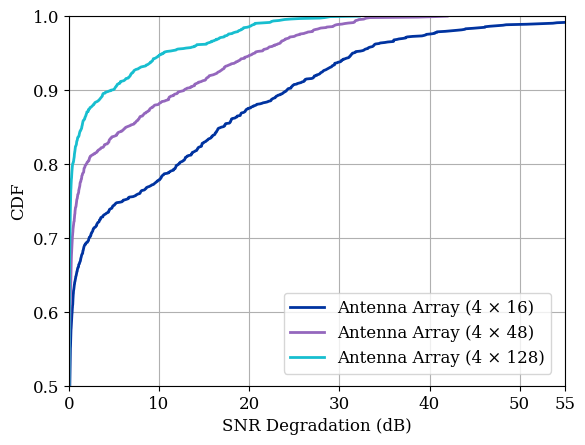

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    "font.size": 11,
    "legend.fontsize": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})
plt.figure()

# 固定三种颜色
color_list = ['#0033A0', '#9467bd', '#17becf']
pair_colors = {pair: color_list[i % len(color_list)] for i, pair in enumerate(snr_degration_dict)}

# 格式化 pair 显示
def format_pair(pair):
    return f"{pair[0]} × {pair[1]}"

# 绘图
for pair in snr_degration_dict:
    snr_deg_vals = np.sort(snr_degration_dict[pair])
    N = len(snr_deg_vals)
    if N == 0:
        continue
    cdf = np.arange(1, N + 1) / N
    plt.plot(snr_deg_vals, cdf,
             label=f'Antenna Array ({format_pair(pair)})',
             color=pair_colors[pair],
             linewidth=2)

# 坐标轴设置
plt.xlabel("SNR Degradation (dB)")
plt.ylabel("CDF")
plt.xlim([0, 55])
plt.ylim([0.5, 1])
plt.xticks([0,10,20,30,40,50,55])
plt.grid(True)
plt.legend(loc="lower right",
    bbox_to_anchor=(0.99, 0.01))
plt.savefig("ResultPlot/snr_deg_antenna5.pdf", format="pdf", bbox_inches="tight")
plt.savefig("ResultPlot/snr_deg_antenna5.png", format="png", bbox_inches="tight")
plt.show()


Different Satellite Angle

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt

# plt.figure()

# for pair in inr_degration_dict:
#     data = np.array(inr_degration_dict[pair])
    
#     data = data[~np.isnan(data)]
    
#     inr_deg_vals = np.sort(data)
    
#     if len(inr_deg_vals) == 0:
#         continue

#     N = len(inr_deg_vals)
#     cdf = np.arange(1, N + 1) / N
#     plt.plot(inr_deg_vals, cdf, label=f'INR Degradation {pair}')

# plt.title("CDF of INR Degradation for Different Antenna Pairs")
# plt.xlabel("INR Degradation (dB)")
# plt.ylabel("CDF")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()
